In [1]:
import local_models.local_models as lm
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import local_models.loggin
from local_models.TLS_models import CircleRegression, LinearRegression, QuadraticRegression

logger = logging.getLogger(__name__)

np.random.seed(0)
reload(local_models.local_models)
reload(local_models.loggin)
mpl.rcParams['figure.figsize'] = [8.0, 8.0]

In [2]:
K=12
n = 200
noisy_moons, c = sklearn.datasets.make_moons(n_samples=n, noise=.02)

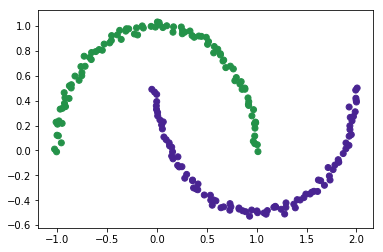

In [3]:
plt.scatter(noisy_moons[:,0], noisy_moons[:,1],c=cmap(c))
plt.show()

In [4]:
quad_models = lm.LocalModels(QuadraticRegression())
quad_models.fit(noisy_moons)

In [5]:
quad_params = quad_models.transform(noisy_moons,k=K)

/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))


In [6]:
circle_models = lm.LocalModels(CircleRegression())
circle_models.fit(noisy_moons)

In [7]:
circle_params = circle_models.transform(noisy_moons,k=K)

/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))


In [8]:
linear_models = lm.LocalModels(LinearRegression())
linear_models.fit(noisy_moons)

In [9]:
linear_params = linear_models.transform(noisy_moons,k=K)

/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))


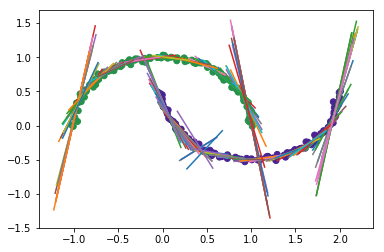

In [10]:
plt.scatter(noisy_moons[:,0], noisy_moons[:,1],c=cmap(c))
span = np.linspace(-0.2,0.2,10)
for i in range(noisy_moons.shape[0]):
    x,y = noisy_moons[i]
    plt.plot(span + x, (1-linear_params[i,0]*(span+x))/linear_params[i,1])
plt.show()

In [11]:
params_plus_moons = np.concatenate((linear_params, quad_params, circle_params, noisy_moons),axis=1)

In [12]:
fica = sklearn.decomposition.FastICA(n_components=3)
fica_params = fica.fit_transform(params_plus_moons)

In [13]:
fica_km = sklearn.cluster.KMeans(2)
fica_km.fit(fica_params)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

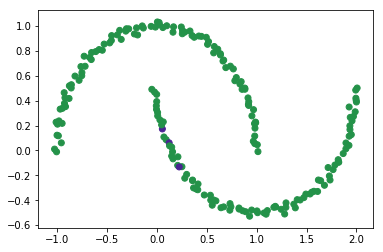

In [14]:
plt.scatter(noisy_moons[:,0], noisy_moons[:,1],c=cmap(fica_km.predict(fica_params)))
plt.show()

In [15]:
def grid_fica(data, models, k, fica_components=3):
    local_modelses = []
    for model in models:
        local_modelses.append(lm.LocalModels(model))
        local_modelses[-1].fit(data)
        
    local_features = []
    for local_model in local_modelses:
        local_features.append(local_model.transform(data, k=k))
    local_features_plus_data = np.concatenate(local_features + [data], axis=1)
    
    data_range = np.stack((np.min(data, axis=0), np.max(data, axis=0))).T
    data_step = ((data_range[:,1] - data_range[:,0])/100)
    grid_limits = tuple(map(lambda i: slice(data_range[i][0], data_range[i][1], data_step[i]), range(data_range.shape[0])))
    g = np.mgrid[grid_limits]
    xx = np.vstack(map(np.ravel, g)).T
    g_like_shape = [-1] + list(g.shape[1:])
    
    transformeds = []
    for transformer in local_modelses:
        transformed = transformer.transform(xx, k)
        transformeds.append(transformed)
        
    transformeds_plus_original_features = np.concatenate(transformeds + [xx], axis=1)
    fica = sklearn.decomposition.FastICA(n_components=3).fit(local_features_plus_data)
    
    fica_km = sklearn.cluster.KMeans(2)
    fica_km.fit(local_features_plus_data)
    
    return fica, fica.transform(transformeds_plus_original_features).T.reshape(g_like_shape), fica_km.predict(local_features_plus_data), grid_limits
    

In [16]:
g = np.mgrid[-1:2:0.03, -1:1:0.02]
xx = np.vstack(map(np.ravel, g)).T

In [17]:
quad_transform_grid = quad_models.transform(xx,k=K)

/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))


In [18]:
quad_transform_grid_unraveled = quad_transform_grid.T.reshape((-1,100,100))

In [19]:
circle_transform_grid = circle_models.transform(xx,k=K)

/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))


In [20]:
circle_transform_grid_unraveled = circle_transform_grid.T.reshape((-1,100,100))

In [21]:
linear_transform_grid = linear_models.transform(xx,k=K)
linear_transform_grid_unraveled = linear_transform_grid.T.reshape((-1,100,100))

/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))


In [22]:
fica_grid = np.concatenate((linear_transform_grid, quad_transform_grid, circle_transform_grid, xx), axis=1)
fica_grid = fica.transform(fica_grid)
fica_grid_unraveled = fica_grid.T.reshape((-1,100,100))

In [23]:
pred = fica_km.predict(fica_params[:,:1])
pred = np.logical_not(pred) if np.sign(pred.shape[0]/2 - np.sum(np.logical_xor(pred,c))) < 0 else pred
plt.imshow(fica_grid_unraveled[0].T, cmap='hot', interpolation='nearest', extent=[-1,2,-1,1], origin='lower')
plt.scatter(noisy_moons[:,0], noisy_moons[:,1],c=cmap(c))
plt.scatter(noisy_moons[:,0], noisy_moons[:,1],c=cmap(pred), s=2)
plt.show()

ValueError: Incorrect number of features. Got 1 features, expected 3

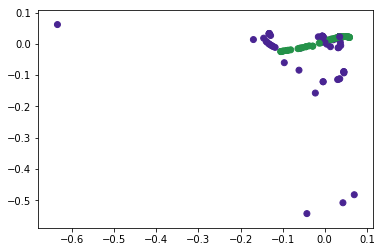

In [24]:
plt.scatter(fica_params[:,0], fica_params[:,1], c=cmap(c))
plt.show()

In [25]:
fica_moons = sklearn.decomposition.FastICA(n_components=2)
fica_moons_transformed = fica_moons.fit_transform(noisy_moons)

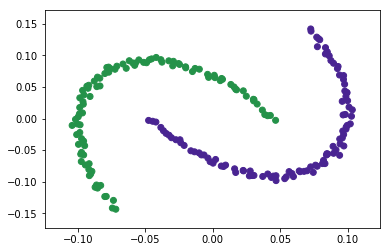

In [26]:
plt.scatter(fica_moons_transformed[:,0], fica_moons_transformed[:,1], c=cmap(c))
plt.show()

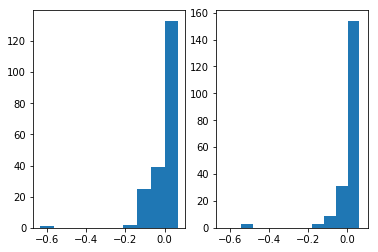

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
ax1.hist(fica_params[:,0])
ax2.hist(fica_params[:,1])
plt.show()

In [28]:
linear_params

array([[ 0.84998072,  0.54574093],
       [ 0.49010481, -0.72040588],
       [ 9.13313384,  2.76267266],
       [-0.98580483,  0.17125411],
       [ 0.52950346, -0.46200696],
       [ 0.53499726, -0.37573536],
       [ 0.99618428,  0.15381753],
       [-0.22691376, -2.49300505],
       [ 0.92804174,  0.38243737],
       [ 0.24948003, -1.48871366],
       [-0.29872313,  0.96397242],
       [ 5.83389313,  4.05358983],
       [ 0.53314743, -0.37938748],
       [ 0.31670626, -1.32711936],
       [-0.82701752,  0.56761957],
       [ 0.99422526,  0.17782478],
       [ 0.50857821,  0.86421268],
       [ 1.21490043, -1.5038172 ],
       [ 0.32203909,  0.95124085],
       [-0.69805905,  0.72138432],
       [ 0.53514917, -0.26059608],
       [-0.24608711, -2.53213041],
       [ 0.22421697,  0.98097044],
       [ 0.39857712, -1.0812849 ],
       [-0.19904655,  0.98831276],
       [ 6.58640918,  4.6907244 ],
       [ 0.53314743, -0.37938748],
       [ 0.53410755, -0.2241497 ],
       [ 6.5607027 ,

<IPython.core.display.Javascript object>


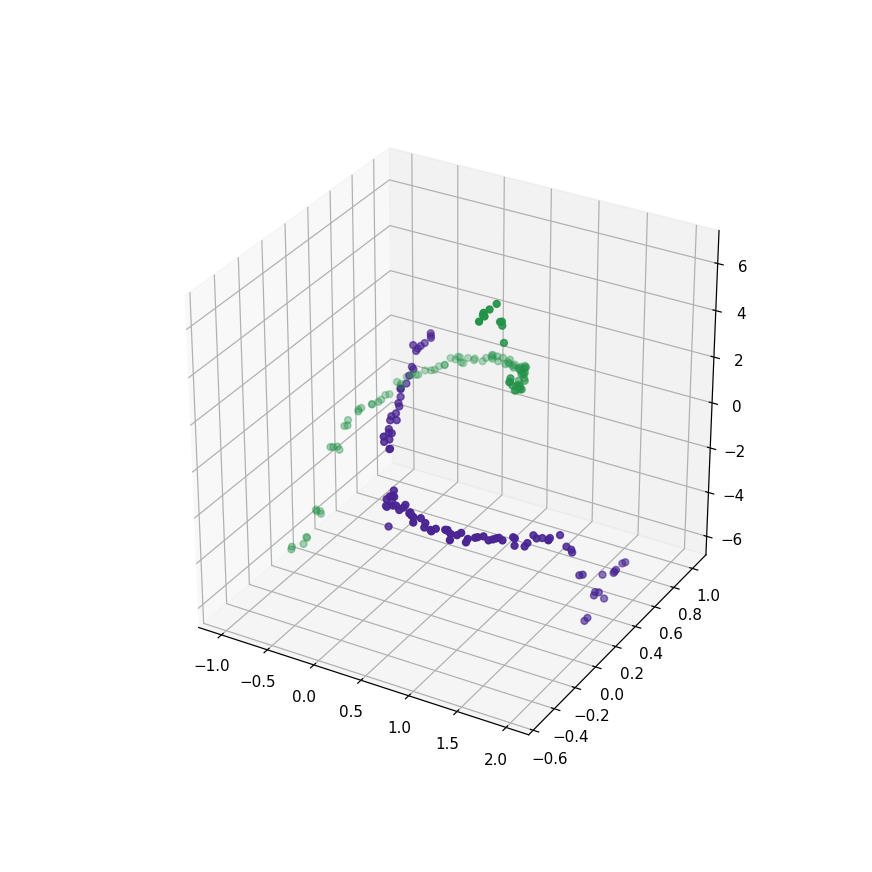

In [29]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(noisy_moons[:,0], noisy_moons[:,1], linear_params[:,0]/linear_params[:,1], c=cmap(c))

In [30]:
%matplotlib inline

In [31]:
local_models.loggin.fixed_width_formatter(0.0022337,10)

' 0.0022337'

In [32]:
#extent = sum([[grid_limits[i], grid_limits[i+1]] for i in range(0, len(grid_limits), 3)])

In [ ]:
n = 200
noise_levels = np.linspace(0,0.3,15)
ks = [4,6,8,10,12,14,16,18,22,26,30,35,40]
time_log = local_models.loggin.TimeLogger(logger=logger, how_often=1, total=len(noise_levels)*len(ks))
for noise_level in noise_levels:
    for k in ks:
        with time_log:
            logger.info("producing figure for noise_level={} and k={}".format(noise_level, k))
            try:
                noisy_moons, c = sklearn.datasets.make_moons(n_samples=n, noise=noise_level)
                fica, fica_grid, fica_pred, grid_limits = grid_fica(
                    noisy_moons, 
                    [LinearRegression(), QuadraticRegression(), CircleRegression()], 
                    k, 
                    fica_components=1
                )
                logger.info(grid_limits)
                fica_pred = np.logical_not(fica_pred) if np.sign(fica_pred.shape[0]/2 - np.sum(np.logical_xor(fica_pred,c))) < 0 else fica_pred
                extent = sum([[grid_limits[i].start, grid_limits[i].stop] for i in range(len(grid_limits))],[])
                
                plt.figure()
                plt.imshow(fica_grid[0].T, cmap='hot', interpolation='nearest', extent=extent, origin='lower')
                plt.scatter(noisy_moons[:,0], noisy_moons[:,1],c=cmap(c))
                plt.scatter(noisy_moons[:,0], noisy_moons[:,1],c=cmap(fica_pred), s=2)
                plt.savefig("../data/moons/fica_features/local_features_moons_{}_{}.png".format(noise_level, k))
            except BaseException as e:
                logger.error("error", exc_info=True)
                raise e

/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: Run

/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: Run

/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: Run

/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scot

/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/scot

/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scot

/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scot

/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scot

/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scot

/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))
/home/scott/python_packages/local_models/local_models/loggin.py:5: RuntimeWarning: divide by zero encountered in log10
  places = np.log10(np.abs(number))


In [ ]:
plt.scatter(xx[:,0], xx[:,1], c=cmap(pred), s=4)
#plt.scatter(x,y, c=cmap(clf.predict(quad_params)), linewidths=1, edgecolors='k')

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline

In [ ]:
print(animation.writers.list())

In [ ]:
xdata, ydata = x, y
offsets = np.stack((xdata, ydata)).T
multioffsets = []
for i in range(100):
    offsets[:,1] += np.random.normal(0,0.05,offsets.shape[0])
    multioffsets.append(np.copy(offsets))

fig = plt.figure()
decision_surface = plt.scatter(xx[:,0], xx[:,1], c=cmap(pred), s=6, animated=True)
scat = plt.scatter(x,y, c=cmap(clf.predict(quad_params)), linewidths=1, edgecolors='k', animated=True)

def init():
    return scat, decision_surface

def update(frame):
    offsets = multioffsets[frame]
    models.fit(offsets[:,:1], offsets[:,1:], offsets)
    pred = clf.predict(models.transform(xx,k=k))
    decision_surface.set_color(cmap(pred))
    scat.set_offsets(np.copy(multioffsets[frame]))
    return scat, decision_surface


ani = FuncAnimation(fig, update, frames=range(100),
                    init_func=init, blit=True)

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='CScott!'), bitrate=1800)
ani.save('ani_k10_double.mp4', writer=writer)

HTML(ani.to_html5_video())
#offsets[:,1] += np.random.normal(0,0.05,offsets.shape[0])
#scat.set_offsets(offsets)
#scat